# Numpyro Intro

In [1]:
import numpy as np
import pandas as pd

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import utils
from utils.analysis import precis
from utils.plots import scatter, shade
utils.init()

In [2]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")

In [3]:
dset.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [4]:
standardize = lambda x: (x - x.mean()) / x.std()

dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

## Model

In [5]:
def model(marriage=None, age=None, divorce=None):
    a = numpyro.sample("a", dist.Normal(0.0, 0.2))
    M, A = 0.0, 0.0
    if marriage is not None:
        bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * marriage
    if age is not None:
        bA = numpyro.sample("bA", dist.Normal(0.0, 0.5))
        A = bA * age
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu = a + M + A
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

## NUTS Inference

In [6]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=4000)

In [8]:
mcmc.run(rng_key_, 
         marriage=dset.MarriageScaled.values, 
         divorce=dset.DivorceScaled.values
)


sample: 100%|███████████████████████████| 5000/5000 [00:04<00:00, 1160.40it/s, 7 steps of size 7.47e-01. acc. prob=0.92]


In [9]:
samples_1 = mcmc.get_samples()
precis(samples_1)

,mean,sd,5.5%,94.5%
a,0.00,0.11,-0.18,0.19
bM,0.35,0.13,0.17,0.58
sigma,0.95,0.10,0.78,1.08


## Prior Predictive

In [10]:
from numpyro.infer import Predictive

In [11]:
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)

In [12]:
priors = prior_predictive(rng_key_, 
                          marriage=dset.MarriageScaled.values)
prpd = priors["obs"]

In [15]:
mean_pred = prpd.mean(0)

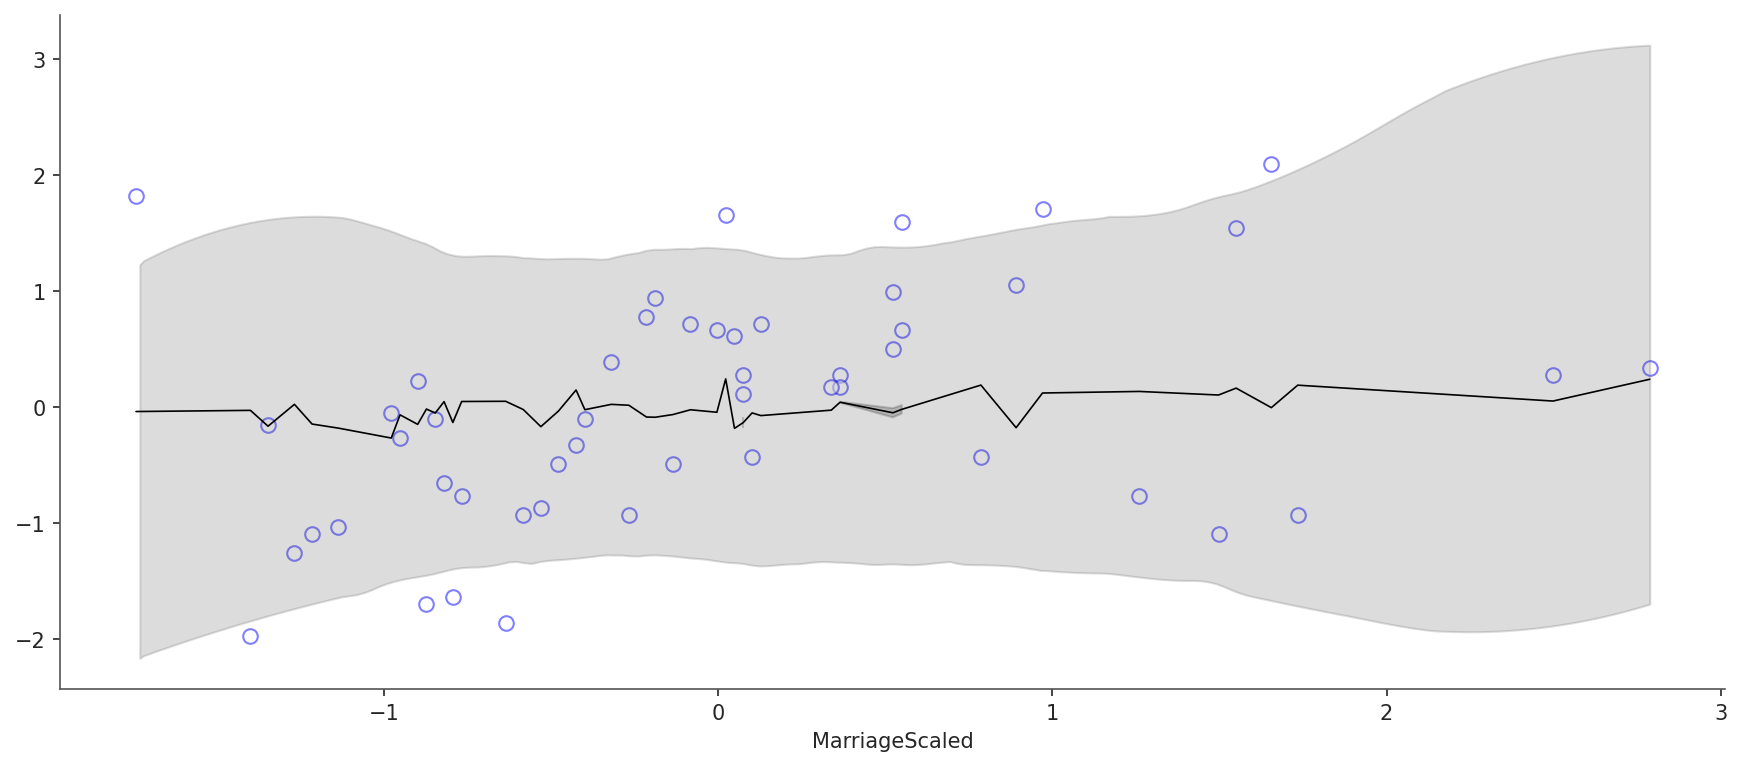

In [17]:
ax = plt.subplot()
sns.lineplot(x=dset.MarriageScaled, y=mean_pred, color="k")
scatter(dset.MarriageScaled, dset.DivorceScaled, ax)
shade(dset.MarriageScaled, np.array(prpd), ax);

## Posterior predictive

In [21]:
rng_key, rng_key_ = random.split(rng_key)
ppd = Predictive(model, samples_1)
predictions = ppd(rng_key_, marriage=dset.MarriageScaled.values)["obs"]
df = dset.filter(["Location"])
df["Mean Predictions"] = jnp.mean(predictions, axis=0)
df.head()

,Location,Mean Predictions
0,Alabama,-0.004843
1,Alaska,0.538986
2,Arizona,0.018787
3,Arkansas,0.593106
4,California,-0.073870


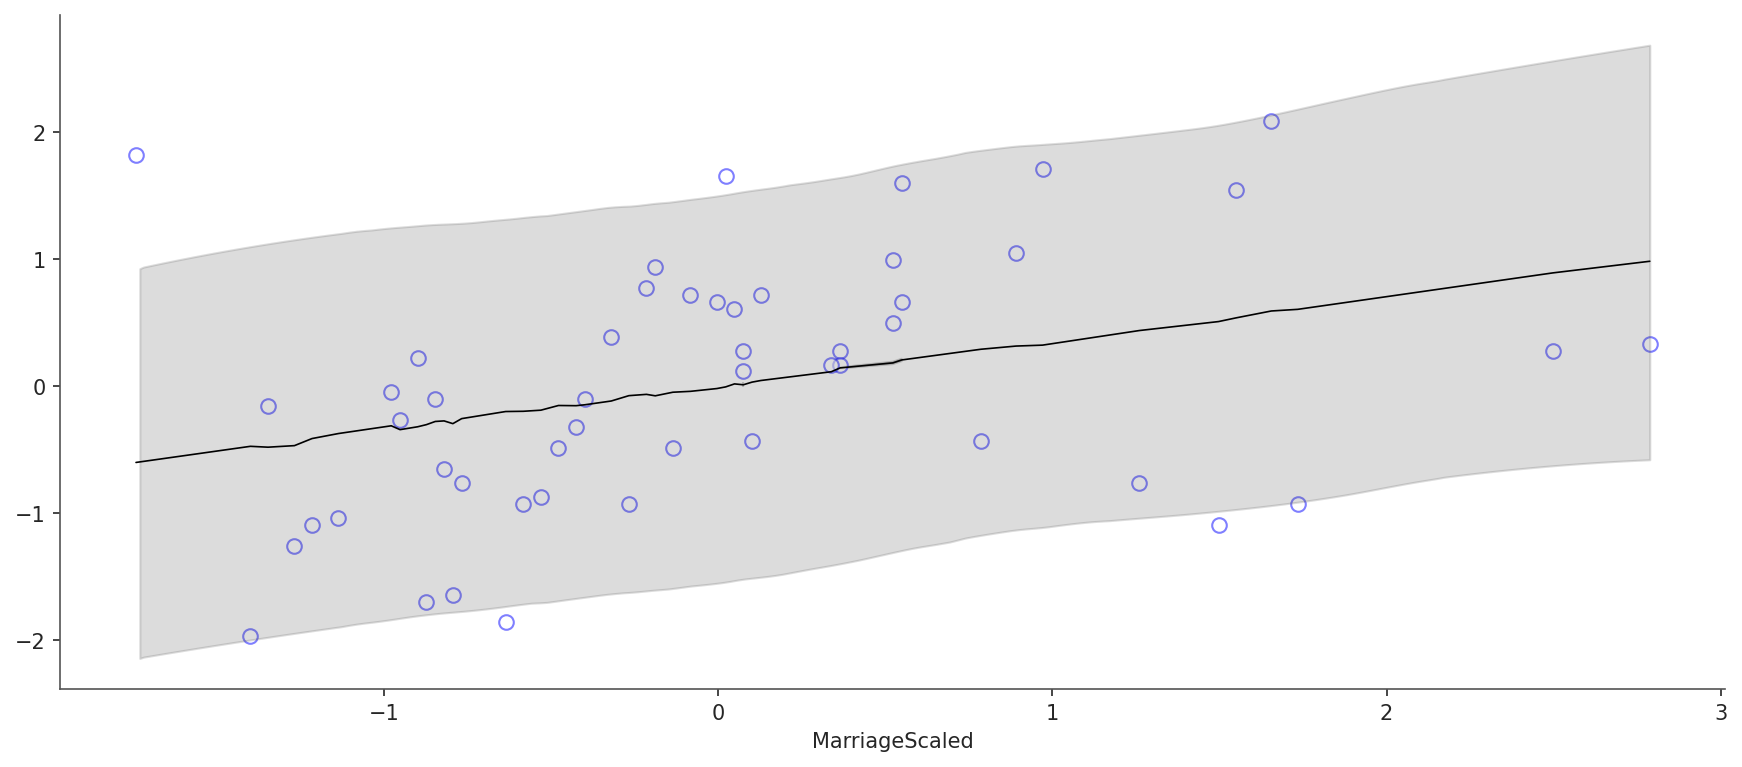

In [22]:
mean_pred = predictions.mean(0)
ax = plt.subplot()
sns.lineplot(x=dset.MarriageScaled, y=mean_pred, color="k")
scatter(dset.MarriageScaled, dset.DivorceScaled, ax)
shade(dset.MarriageScaled, np.array(predictions), ax);

## Stochastic VI with quadratic approximation

In [103]:
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.infer import SVI, Trace_ELBO

def model(marriage=None, age=None, divorce=None):
    a = numpyro.sample("a", dist.Normal(0.0, 0.2))
    M, A = 0.0, 0.0
    if marriage is not None:
        bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * marriage
    if age is not None:
        bA = numpyro.sample("bA", dist.Normal(0.0, 0.5))
        A = bA * age
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu = a + M + A
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

guide = AutoLaplaceApproximation(model)
optimizer = numpyro.optim.Adam(step_size=0.0005)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
seed = random.PRNGKey(0)
svi_result = svi.run(seed, 2000, 
                     marriage=dset.MarriageScaled.values,
                     divorce=dset.DivorceScaled.values)

100%|███████████████████████| 2000/2000 [00:00<00:00, 2999.84it/s, init loss: 962.7465, avg. loss [1901-2000]: 161.0595]


In [104]:
post = guide.sample_posterior(seed, 
                              svi.get_params(svi_result.state), 
                              (1000,))

In [105]:
precis(post)

,mean,sd,5.5%,94.5%
a,0.00,0.07,-0.10,0.11
bM,1.12,0.14,0.87,1.30
sigma,0.49,0.04,0.43,0.56


In [110]:
ppd = Predictive(model, post)
pred = ppd(seed, marriage=dset.MarriageScaled.values)["obs"]

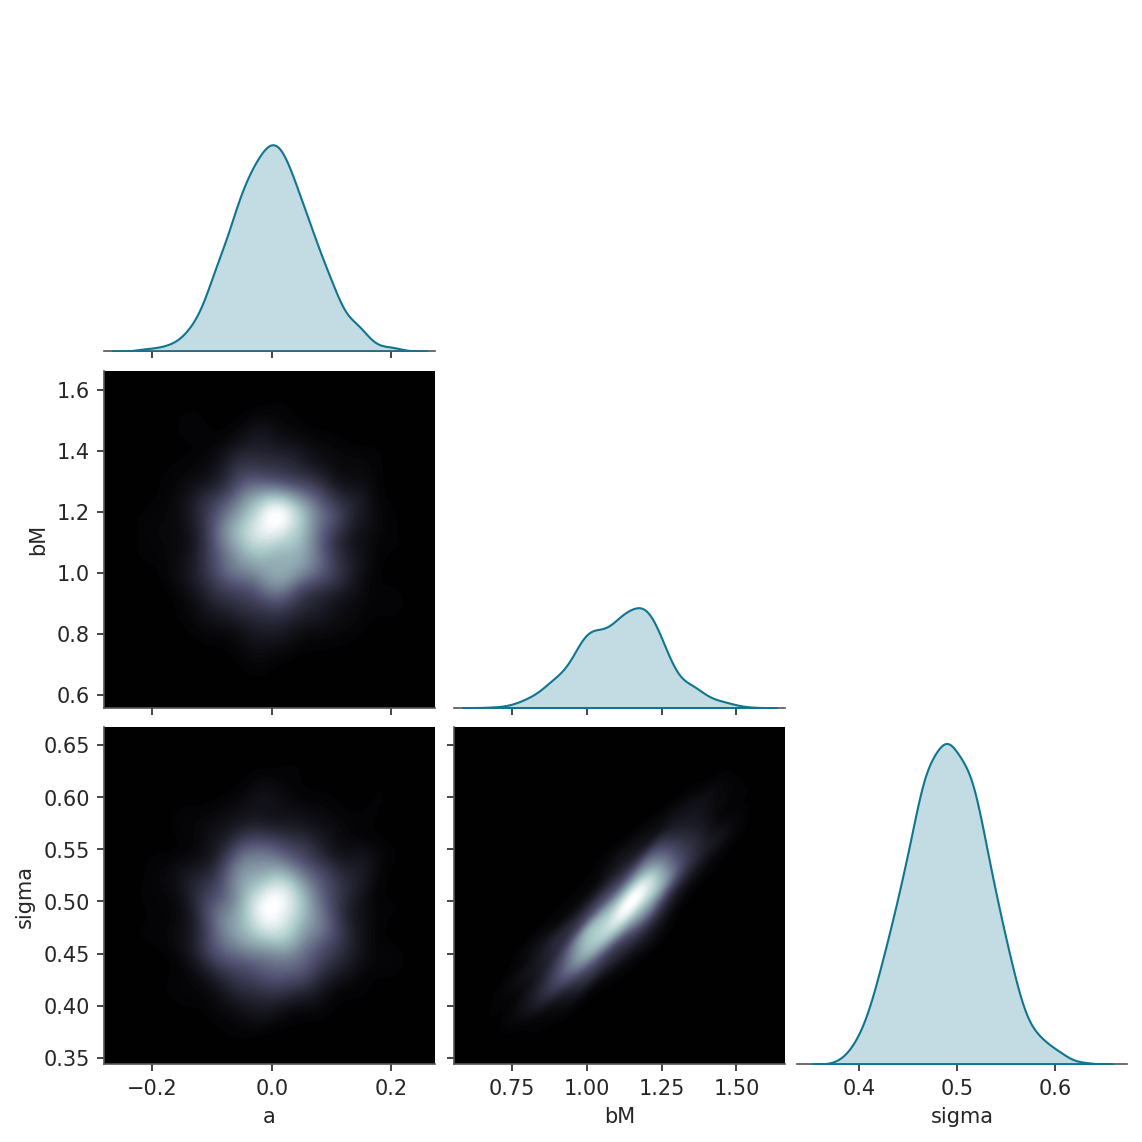

In [211]:
g = sns.PairGrid(pd.DataFrame(post), corner=True)
g.map_lower(sns.kdeplot, cmap="bone", fill=True, thresh=0, levels=100)
g.map_diag(sns.kdeplot, fill=True);

In [ ]:
# twilight_shifted, PuBu_r, terrain, bone, mako